# Template

In [ ]:
import numpy as np
import time
from datetime import datetime, timedelta
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Database, StimPolarity, Experiment

token = "XSALK6J9C4" 
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')  # Electrodes that you can use

# Configure stimulation parameters for each electrode
stim_params = []
for index in exp.electrodes:
    stim_param = StimParam()
    stim_param.index = index  # Set to current electrode in the loop

    # Configure unique trigger key for each electrode, assuming it's mapped to the index
    stim_param.trigger_key = index

    # Setting common stimulation parameters
    stim_param.phase_duration1 = 200.0
    stim_param.phase_duration2 = 200.0
    stim_param.phase_amplitude1 = 8.0
    stim_param.phase_amplitude2 = 8.0
    stim_param.stim_shape = StimShape.Biphasic
    stim_param.polarity = StimPolarity.PositiveFirst
    stim_param.enable_amp_settle = True
    stim_param.pre_stim_amp_settle = 0.0
    stim_param.post_stim_amp_settle = 1000.0
    stim_param.enable_charge_recovery = True
    stim_param.post_charge_recovery_on = 0.0
    stim_param.post_charge_recovery_off = 100.0
    stim_param.interphase_delay = 0.0

    stim_params.append(stim_param)

intan = IntanSoftware()
trigger_gen = Trigger()

try:
    if exp.start():  # Signal the start of an experiment to all users
        # Measure impedance
        intan.impedance()

        # Disable Variation STD (keep a fixed threshold)
        intan.var_threshold(False)

        # Send stim parameters
        intan.send_stimparam(stim_params)

        # Manually send trigger signals
        for stim_param in stim_params:
            trigger = np.zeros(16, dtype=np.uint8)
            trigger[stim_param.trigger_key] = 1

            for _ in range(40):  # Send trigger signal 40 times for each electrode
                time.sleep(5)  # Wait 5 seconds between each trigger
                trigger_gen.send(trigger)

        # Disable all stims
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)

finally:
    # Close the connection to trigger generator
    trigger_gen.close()
    # Enable variation threshold again
    intan.var_threshold(True)
    # Close the connection to intan software
    intan.close()
    # Signal the end of an experiment to all users
    exp.stop()

# Stimulation 1 (biphasic with fractal amplitude, oscillatory amplitude, components)

In [ ]:
import numpy as np
import time
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Experiment, StimPolarity
from fbm import FBM


# Function to generate an oscillatory sequence (e.g., alpha rhythm)
def generate_oscillatory_sequence(length, frequency, amplitude=1):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = amplitude * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence


# Set the experiment token and initialize the experiment
token = "XSALK6J9C4"
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')

# Initialize a list to store stimulation parameters for each electrode
stim_params = []

for index in exp.electrodes:
    # Create a new instance of StimParam for each electrode
    stim_param = StimParam()
    stim_param.index = index  # Set to the current electrode

    # Set common stimulation parameters
    stim_param.trigger_delay = 0
    stim_param.stim_shape = StimShape.Biphasic
    stim_param.polarity = StimPolarity.PositiveFirst
    stim_param.phase_duration1 = 200.0
    stim_param.phase_duration2 = 200.0
    stim_param.enable_amp_settle = True
    stim_param.pre_stim_amp_settle = 0.0
    stim_param.post_stim_amp_settle = 1000.0
    stim_param.enable_charge_recovery = True
    stim_param.post_charge_recovery_on = 0.0
    stim_param.post_charge_recovery_off = 100.0
    stim_param.interphase_delay = 0.0

    # Generate amplitude sequences
    fractal_amplitude = generate_fbmn_sequence(40, 1, 8, 0.8)  # Hurst exponent of 0.8 for fractal amplitude
    oscillatory_amplitude = generate_oscillatory_sequence(40, frequency=10, amplitude=1)  # Alpha rhythm (10 Hz)

    # Set the trigger_key and phase amplitudes for each stimulation
    stim_param.trigger_key = index  # Unique trigger key for each electrode
    stim_param.phase_amplitude1 = fractal_amplitude[index % len(fractal_amplitude)] + oscillatory_amplitude[index % len(oscillatory_amplitude)]
    stim_param.phase_amplitude2 = fractal_amplitude[index % len(fractal_amplitude)] + oscillatory_amplitude[index % len(oscillatory_amplitude)]

    # Append the configured stimulation parameters to the list
    stim_params.append(stim_param)

# Initialize the IntanSoftware and Trigger objects
intan = IntanSoftware()
trigger_gen = Trigger()


# Initialize the IntanSoftware and Trigger objects
intan = IntanSoftware()
trigger_gen = Trigger()

# Try to start the experiment
try:
    if exp.start():
        
        # Send stimulation parameters to the hardware
        intan.send_stimparam(stim_params)

        # Configure and send triggers for each electrode
        for stim_param in stim_params:
            trigger = np.zeros(16, dtype=np.uint8)
            trigger[stim_param.trigger_key] = 1
            for _ in range(40):  # Send trigger signal 40 times for each electrode
                trigger_gen.send(trigger)
                time.sleep(5)  # Sleep to control timing between triggers

        # Disable all stimulations
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)

finally:

# Handle exceptions and perform cleanup
finally:
    # Close the connection to the trigger generator
    trigger_gen.close()
    # Enable variation threshold again for electrode impedance measurement
    intan.var_threshold(True)
    # Close the connection to the Intan software
    intan.close()
    # Signal the end of the experiment to all users
    exp.stop()

# Stimulation 2 (ecog based neuromimetic)

In [20]:
import numpy as np
from scipy.signal import hilbert

# Function to generate base ECoG-like signals within the specified range
def generate_ecog_like_base_signals(length, num_signals=8):
    signals = np.random.uniform(min_volt, max_volt, (num_signals, length))
    return signals

# Function to scale signals to a specific bit depth
def scale_signals_to_bit_depth(modified_signals, bit_depth):
    # Calculate the min and max values within the desired range
    min_val, max_val = min_volt, max_volt

    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)

    # Scale the signals to the specified bit depth while preserving the range
    scaled_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_val - min_val) + min_val

    return modified_signals

# Function to apply amplitude variability while keeping the signals within the specified range
def apply_amplitude_variability(modified_signals, variability_factor):
    # Apply amplitude variability to each signal individually
    for i in range(modified_signals.shape[0]):
        # Calculate the scaling factor for each signal
        current_std = np.std(modified_signals[i])
        if current_std == 0:
            continue  # Skip if standard deviation is zero to avoid division by zero
        scaling_factor = np.sqrt(variability_factor) / current_std

        # Generate scaled noise for each signal
        scaled_noise = np.random.normal(0, scaling_factor, modified_signals.shape[1])

        # Add the scaled noise to the signal
        modified_signals[i] += scaled_noise

    # Scale the entire signal set to fit within the min_volt and max_volt range
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    modified_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return modified_signals

# Function to apply variance while keeping the signals within the specified range
def apply_variance(modified_signals, variance):
    for i in range(modified_signals.shape[0]):
        # Generate noise for each signal based on the specified variance
        noise = np.random.normal(0, np.sqrt(variance), modified_signals.shape[1])

        # Add the noise to the signal
        modified_signals[i] += noise

    # Scale the entire signal set to fit within the min_volt and max_volt range
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    modified_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return modified_signals

# Function to apply signal with standard deviation while keeping the signals within the specified range
def apply_signal_with_std(modified_signals, std_dev):
    for i in range(modified_signals.shape[0]):
        # Calculate the scaling factor for each individual signal
        current_std = np.std(modified_signals[i])
        if current_std == 0:
            continue  # Skip if standard deviation is zero to avoid division by zero
        scaling_factor = std_dev / current_std

        # Apply the scaled noise to each individual signal
        modified_signals[i] += np.random.normal(0, scaling_factor * std_dev, modified_signals.shape[1])

    # Scale the entire signal set to fit within the min_volt and max_volt range
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    modified_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return modified_signals


# Function to apply signal with RMS value
def apply_signal_with_rms(modified_signals, rms_value):
    current_rms = np.sqrt(np.mean(modified_signals**2, axis=1, keepdims=True))
    scaling_factor = np.minimum(1.0, rms_value / current_rms)
    modified_signals *= scaling_factor
    return modified_signals



    
# Function to add peaks
def add_peaks(modified_signals, num_peaks, peak_height):
    if len(modified_signals) == 0:
        raise ValueError("Input modified_signals array must not be empty")
    num_signals, signal_length = modified_signals.shape
    scaling_factor = np.maximum(min_volt / np.min(modified_signals), max_volt / np.max(modified_signals))
    
    for i in range(num_signals):
        for _ in range(num_peaks):
            peak_position = np.random.randint(0, signal_length)
            modified_signals[i, peak_position] += peak_height * scaling_factor
            # Ensure that the modified signal does not exceed the specified range
            modified_signals[i, peak_position] = np.clip(modified_signals[i, peak_position], min_volt, max_volt)
            
    return modified_signals


# Function to apply moving average
def apply_moving_average(modified_signals, window_size):  
    for i in range(len(modified_signals)):
        length = len(modified_signals[i])
        if length >= window_size:
            cumsum_vec = np.cumsum(np.insert(modified_signals[i], 0, 0))
            moving_average = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
            # Apply the moving average only to the middle part of the signal
            modified_signals[i, window_size//2:-window_size//2+1] = moving_average
    return modified_signals

# Function to apply fractal structure
def apply_fractal_structure(modified_signals, fractal_dimension):
    length = modified_signals.shape[1]
    fBm_signal = np.zeros_like(modified_signals)

    # Calculate Hurst exponent from fractal dimension
    hurst_exponent = 2 - fractal_dimension

    for i in range(1, length):
        scale = (i ** (2 * hurst_exponent)) - ((i-1) ** (2 * hurst_exponent))
        fBm_signal[:, i] = fBm_signal[:, i-1] + np.random.normal(0, np.sqrt(scale), modified_signals.shape[0])

    # Scale fBm_signal to match the original signal's range
    max_signal = np.max(fBm_signal, axis=1, keepdims=True)
    min_signal = np.min(fBm_signal, axis=1, keepdims=True)
    fBm_signal = (fBm_signal - min_signal) / (max_signal - min_signal)
    fBm_signal *= (max_volt - min_volt)
    fBm_signal += min_volt

    return modified_signals
    
# Function to apply zero-crossing rate
def apply_zero_crossing_rate(modified_signals, target_rate):
    def calculate_zero_crossing_rate(sig):
        zero_crossings = np.where(np.diff(np.sign(sig)))[0]
        return len(zero_crossings) / len(sig)

    for i in range(len(modified_signals)):
        current_rate = calculate_zero_crossing_rate(modified_signals[i])
        factor = target_rate / current_rate if current_rate > 0 else 1.0
        modified_signals[i] *= factor
    return modified_signals

# Function to apply Arnold tongues
def apply_arnold_tongues(modified_signals, min_freq, max_freq, blend_factor):
    num_signals, signal_length = modified_signals.shape

    for i in range(num_signals):
        # Generate a random K within a more controlled range
        K = np.random.uniform(0.1 * max_volt, 0.5 * max_volt)  # Reduced amplitude range

        # Generate an Arnold tongue pattern with the specified frequency range
        omega = np.random.uniform(min_freq, max_freq)  # Use the provided frequency range
        t = np.linspace(0, 2 * np.pi, signal_length)
        arnold_tongue_pattern = np.sin(t * omega) * K
        
        # Introduce additional harmonics or noise to the pattern
        harmonics = np.random.choice([2, 3, 4], size=1)
        noise = np.random.uniform(-0.1 * K, 0.1 * K, size=signal_length)
        arnold_tongue_pattern += (np.sin(t * omega * harmonics) + noise) * K * 0.5

        # Blend the Arnold tongue pattern with the original signal
        modified_signals[i, :] = (1 - blend_factor) * modified_signals[i, :] + blend_factor * arnold_tongue_pattern

    # Normalize the signals
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    normalized_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return normalized_signals

def apply_phase_synchronization(modified_signals, global_sync_level, pairwise_sync_level, sync_factor=0.05):
    num_signals, length = modified_signals.shape
    common_phase = np.linspace(0, 2 * np.pi * global_sync_level, length)

    # Apply global synchronization
    for i in range(num_signals):
        signal_fft = np.fft.fft(modified_signals[i])
        amplitude = np.abs(signal_fft)
        phase = np.angle(signal_fft)
        
        # Adjust phase globally
        global_phase_shift = sync_factor * np.interp(common_phase, (common_phase.min(), common_phase.max()), (-np.pi, np.pi))
        adjusted_phase = phase + global_phase_shift
        modified_signals[i] = np.fft.ifft(amplitude * np.exp(1j * adjusted_phase)).real

    # Apply pairwise synchronization more selectively
    for i in range(num_signals):
        for j in range(i + 1, num_signals):
            # Calculate pairwise phase difference
            phase_diff = np.angle(np.fft.fft(modified_signals[i])) - np.angle(np.fft.fft(modified_signals[j]))
            phase_diff_adjustment = np.interp(phase_diff, (-np.pi, np.pi), (-pairwise_sync_level, pairwise_sync_level))

            # Apply the phase adjustment selectively
            signal_fft_i = np.fft.fft(modified_signals[i])
            signal_fft_j = np.fft.fft(modified_signals[j])
            adjusted_phase_i = np.angle(signal_fft_i) + phase_diff_adjustment * sync_factor
            adjusted_phase_j = np.angle(signal_fft_j) - phase_diff_adjustment * sync_factor

            # Apply the adjusted phases
            modified_signals[i] = np.fft.ifft(np.abs(signal_fft_i) * np.exp(1j * adjusted_phase_i)).real
            modified_signals[j] = np.fft.ifft(np.abs(signal_fft_j) * np.exp(1j * adjusted_phase_j)).real

    # Rescale the signals
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    modified_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return modified_signals


def apply_transfer_entropy(modified_signals, influence_factor, max_influence):
    num_signals = len(modified_signals)
    max_length = max(len(signal) for signal in modified_signals)
    
    # Normalize interaction weights to sum up to the influence factor
    interaction_weights = np.random.uniform(0, 1, (num_signals, num_signals))
    interaction_weights /= interaction_weights.sum(axis=1, keepdims=True)
    interaction_weights *= influence_factor
    
    for i in range(1, max_length):
        # Calculate the influenced signals
        influenced_signals = np.dot(interaction_weights, [signal[i - 1] if i < len(signal) else signal[-1] for signal in modified_signals])
        
        # Calculate the maximum possible influence to stay within the specified voltage range
        max_possible_influence = (max_volt - min_volt) / max_length
        
        # Scale down the influenced signals if necessary
        if np.max(np.abs(influenced_signals)) > max_possible_influence:
            scaling_factor = max_possible_influence / np.max(np.abs(influenced_signals))
            influenced_signals *= scaling_factor
        
        # Add the influenced signals to the original signals
        for j in range(num_signals):
            if i < len(modified_signals[j]):
                modified_signals[j][i] += influenced_signals[j]

    return modified_signals

# Function to apply Hilbert-Huang transform
def apply_hilbert_huang(modified_signals):
    for i in range(len(modified_signals)):
        signal = modified_signals[i]
        
        # Calculate the amplitude for the low-frequency component (lowest 10%)
        low_freq_amplitude = 0.05 * (max_volt - min_volt)
        low_freq_signal = low_freq_amplitude * np.sin(2 * np.pi * 0.1 * np.arange(len(signal)))
        
        # Calculate the amplitude for the high-frequency component (highest 10%)
        high_freq_amplitude = 0.05 * (max_volt - min_volt)
        high_freq_noise = high_freq_amplitude * np.random.randn(len(signal))
        
        # Combine the components
        modulated_signal = signal + low_freq_signal + high_freq_noise

        # Clip the signal to the specified range
        modulated_signal = np.clip(modulated_signal, min_volt, max_volt)

        modified_signals[i] = modulated_signal

    return modified_signals

# Function to apply spectral centroids
def apply_spectral_centroids(modified_signals, centroid_factor, edge_density_factor):
    for i in range(modified_signals.shape[0]):
        fft_spectrum = np.fft.fft(modified_signals[i])
        freq = np.fft.fftfreq(len(modified_signals[i]))
        centroid = np.sum(freq * np.abs(fft_spectrum)) / np.sum(np.abs(fft_spectrum))
        edge_density = np.sum(np.abs(np.diff(fft_spectrum))) / np.sum(np.abs(fft_spectrum))
        adjusted_spectrum = fft_spectrum * (centroid_factor * centroid + edge_density_factor * edge_density)
        modified_signals[i] = np.fft.ifft(adjusted_spectrum).real
    return modified_signals
    
# Function to apply dynamic time warping
def apply_dynamic_time_warping(modified_signals, reference_signal, warping_factor, min_volt, max_volt):
    modified_signals_aligned = []

    reference_signal = np.array(reference_signal)  # Convert the reference signal to a numpy array

    for signal in modified_signals:
        signal = np.array(signal)  # Convert the signal to a numpy array

        # Perform dynamic time warping
        signal_length = len(signal)
        time_vector = np.linspace(0, 1, signal_length)
        reference_time_vector = np.linspace(0, 1, len(reference_signal)) * warping_factor
        modified_signal = np.interp(time_vector, reference_time_vector, reference_signal)

        # Normalize the signal to stay within the desired range
        current_min = np.min(modified_signal)
        current_max = np.max(modified_signal)

        # Calculate the scaling factor to keep the signal within the specified range
        scaling_factor = (max_volt - min_volt) / (current_max - current_min)

        # Apply the scaling factor while preserving the signal's shape
        modified_signal = (modified_signal - current_min) * scaling_factor + min_volt

        modified_signals_aligned.append(modified_signal)

    return np.array(modified_signals)
    
def apply_fft(modified_signals, complexity_factor):
    modified_signals_complexity = []

    for signal in modified_signals:
        # Apply FFT to each signal
        spectrum = np.fft.fft(signal)
        freq = np.fft.fftfreq(len(signal))

        # Calculate the scaling factor to keep the signal within the range
        current_max = np.max(signal)
        current_min = np.min(signal)
        scaling_factor = max_volt / (current_max - current_min)

        # Apply complexity modification
        modified_spectrum = spectrum * (1 + np.random.randn(len(spectrum)) * complexity_factor)
        
        # Transform back to time domain
        modified_signal = np.fft.ifft(modified_spectrum).real
        
        # Scale the signal while preserving the range
        modified_signal = (modified_signal - current_min) * scaling_factor + min_volt
        modified_signals_complexity.append(modified_signal)

    return np.array(modified_signals)

def apply_signal_evolution(modified_signals, evolution_rate):
    modified_signals_evolution = np.zeros_like(modified_signals)
    for i in range(modified_signals.shape[0]):
        modified_signals_evolution[i, 0] = np.random.randn()
        for t in range(1, modified_signals.shape[1]):
            modified_signals_evolution[i, t] = modified_signals_evolution[i, t - 1] + evolution_rate * np.random.randn()
    return modified_signals

def apply_phase_amplitude_coupling(modified_signals, low_freq, high_freq):
    modified_signals_pac = np.zeros_like(modified_signals)
    time = np.linspace(0, 1, modified_signals.shape[1])
    for i in range(modified_signals.shape[0]):
        low_freq_signal = np.sin(2 * np.pi * low_freq * time)
        high_freq_signal = np.sin(2 * np.pi * high_freq * time)
        modified_signals_pac[i] = (1 + low_freq_signal) * high_freq_signal
    return modified_signals

def apply_granger_causality(modified_signals, causality_strength):
    modified_signals_granger = np.copy(modified_signals)
    num_signals, signal_length = modified_signals.shape
    for i in range(1, num_signals):
        for j in range(num_signals):
            if i != j:
                causal_effect = modified_signals[j, :-i] * causality_strength
                modified_signals_granger[i, i:] += causal_effect
    return modified_signals

def apply_multivariate_empirical_mode_decomposition(modified_signals, num_imfs):
    num_channels, signal_length = modified_signals.shape
    memd_signals = np.zeros((num_channels, num_imfs, signal_length))
    for channel in range(num_channels):
        for imf_idx in range(num_imfs):
            imf = np.sin(2 * np.pi * (imf_idx + 1) * np.linspace(0, 1, signal_length))
            amplitude_scaling = np.random.uniform(0.5, 2.0)
            memd_signals[channel, imf_idx, :] = amplitude_scaling * imf
    modified_signals_memd = modified_signals + np.sum(memd_signals, axis=1)
    return modified_signals

def apply_normalized_states(modified_signals, modification_factor, matrix_size, value_range, num_matrices, eigenvalue_subset):
    num_signals, signal_length = modified_signals.shape
    modified_signals = modified_signals.copy()

    # Function to generate a parameterized random Hermitian matrix
    def generate_parameterized_hermitian_matrix(size, value_range):
        A = np.random.uniform(value_range[0], value_range[1], (size, size)) + \
            1j * np.random.uniform(value_range[0], value_range[1], (size, size))
        return A + A.conj().T

    density_diagonals = []
    for _ in range(num_matrices):
        hermitian_matrix = generate_parameterized_hermitian_matrix(matrix_size, value_range)
        eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)
        eigenvalues = eigenvalues[eigenvalue_subset]
        eigenvectors = eigenvectors[:, eigenvalue_subset]
        density_matrix = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T.conj()))
        density_diagonal = np.diag(density_matrix).real
        density_diagonals.append(density_diagonal)

    # Apply modifications using the density diagonals
    for i, signal in enumerate(modified_signals):
        density_diagonal = density_diagonals[i % len(density_diagonals)]
        signal_modification = np.interp(signal, (np.min(signal), np.max(signal)), (np.min(density_diagonal), np.max(density_diagonal)))
        modified_signals[i] = (1 - modification_factor) * signal + modification_factor * signal_modification

    # Normalize the signals
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)
    modified_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_volt - min_volt) + min_volt

    return modified_signals

def final_modified_scale_signals_to_bit_depth(modified_signals, bit_depth):
    # Assuming that the desired final range is defined by global variables min_volt and max_volt
    min_val, max_val = min_volt, max_volt

    # Calculate the current range of the signals
    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)

    # Scale the signals to the specified bit depth
    # The formula maps the current range to the desired range [min_val, max_val]
    scaled_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_val - min_val) + min_val

    return scaled_signals

# Define the list of transformation functions
transformations = [
    lambda x: scale_signals_to_bit_depth(x, bit_depth),
    lambda x: apply_amplitude_variability(x, variability_factor=0.05),
    lambda x: apply_variance(x, variance=0.5),
    lambda x: apply_signal_with_std(x, std_dev=0.5),
    lambda x: apply_signal_with_rms(x, rms_value=0.5),
    lambda x: add_peaks(x, num_peaks=2, peak_height=0.1),  # resting state number of peaks and peak height
    lambda x: apply_fractal_structure(x, fractal_dimension=0.8),  # resting state fractality
    lambda x: apply_moving_average(x, window_size=3),
    lambda x: apply_zero_crossing_rate(x, target_rate=0.1),
    lambda x: apply_arnold_tongues(x, min_freq=0.1, max_freq=0.2, blend_factor=0.1),
    lambda x: apply_phase_synchronization(x,  global_sync_level=.7, pairwise_sync_level=.9, sync_factor=0.1),
    lambda x: apply_transfer_entropy(x, influence_factor=.9, max_influence=4),
    lambda x: apply_hilbert_huang(x),
    lambda x: apply_spectral_centroids(x, centroid_factor=0.8, edge_density_factor=0.8),
    lambda x: apply_dynamic_time_warping(x, reference_signal=np.mean(x, axis=0), warping_factor=0.5, min_volt=min_volt, max_volt=max_volt),
    lambda x: apply_fft(x, complexity_factor=0.5),
    lambda x: apply_signal_evolution(x, evolution_rate=0.8),
    lambda x: apply_phase_amplitude_coupling(x, low_freq=8.0, high_freq=40.0),
    lambda x: apply_granger_causality(x, causality_strength=0.8),
    lambda x: apply_multivariate_empirical_mode_decomposition(x, num_imfs=4),
    lambda x: apply_normalized_states(x, modification_factor=0.1, matrix_size=10, value_range=(-1, 1), num_matrices=5, eigenvalue_subset=slice(0, 5)),
]

# Main function to generate and transform signals
def generate_transformed_signals(signal_length, num_signals, transformation_functions):
    modified_signals = generate_ecog_like_base_signals(signal_length, num_signals)

    for transform in transformation_functions:
        modified_signals = transform(modified_signals)
        # Convert list to NumPy array if necessary
        if isinstance(modified_signals, list):
            modified_signals = np.array(modified_signals)

        if np.isnan(modified_signals).any() or np.isinf(modified_signals).any():
            print(f"NaNs or Infinities found after {transform.__name__}")
        print(f"Range after {transform.__name__}: {modified_signals.min()} to {modified_signals.max()}")

    # Normalize and scale to full 16-bit range
    modified_signals = final_modified_scale_signals_to_bit_depth(modified_signals, 16)
    print(f"Scaled range: {modified_signals.min()} to {modified_signals.max()}")

    return modified_signals

# Main execution
if __name__ == "__main__":
    bit_depth = 16        # Bit depth of the signals
    num_signals = 8      # Number of signals
    sampling_rate = 500   # Sampling rate in Hz
    duration = 1        # Duration in seconds
    length = sampling_rate * duration

    # Global variables for amplitude range
    min_volt = 1e-6  # 1 microvolt
    max_volt = 8e-5  # 8 microvolts

    # Calculate the length of the signals
    length = sampling_rate * duration

    # Generate and transform the ECoG-like signals
    transformed_signals = generate_transformed_signals(length, num_signals, transformations)

    # Convert transformed_signals to a NumPy array to access the shape attribute
    transformed_signals_array = np.array(transformed_signals)

    # Check the shape and a sample of the generated signals
    print(f"Shape of generated ECoG-like signals: {transformed_signals_array.shape}")
    for i in range(8):
        print(f"Sample of signal {i + 1}: {transformed_signals_array[i][:50]}")



Range after <lambda>: 1.0237157341174464e-06 to 7.999353796668062e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1.2986541647370028e-05 to 6.95229506944434e-05
Range after <lambda>: 1.2986541647370028e-05 to 6.95229506944434e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8e-05
Range after <lambda>: 1e-06 to 8.014284883358791e-05
Range after <lambda>: 1e-06 to 7.699875795425402e-05
Range after <lambda>: 1.0455452993456126e-06 to 8.352554552539368e-05
Range after <lambda>: 1.0455452993456126e-06 to 8.352554552539368e-05
Range after <lambda>: 1.0455452993456126e-06 to 8.352554552539368e-05
Range after <lambda>: 1.0455452993456126e-06 to 8.352554552539368e-05
Range after <lambda>: 1.0455452993456126e-06 to 8.352554552539368e-05
Range after <lambda>: 1.0455452993456126

#### Visualize

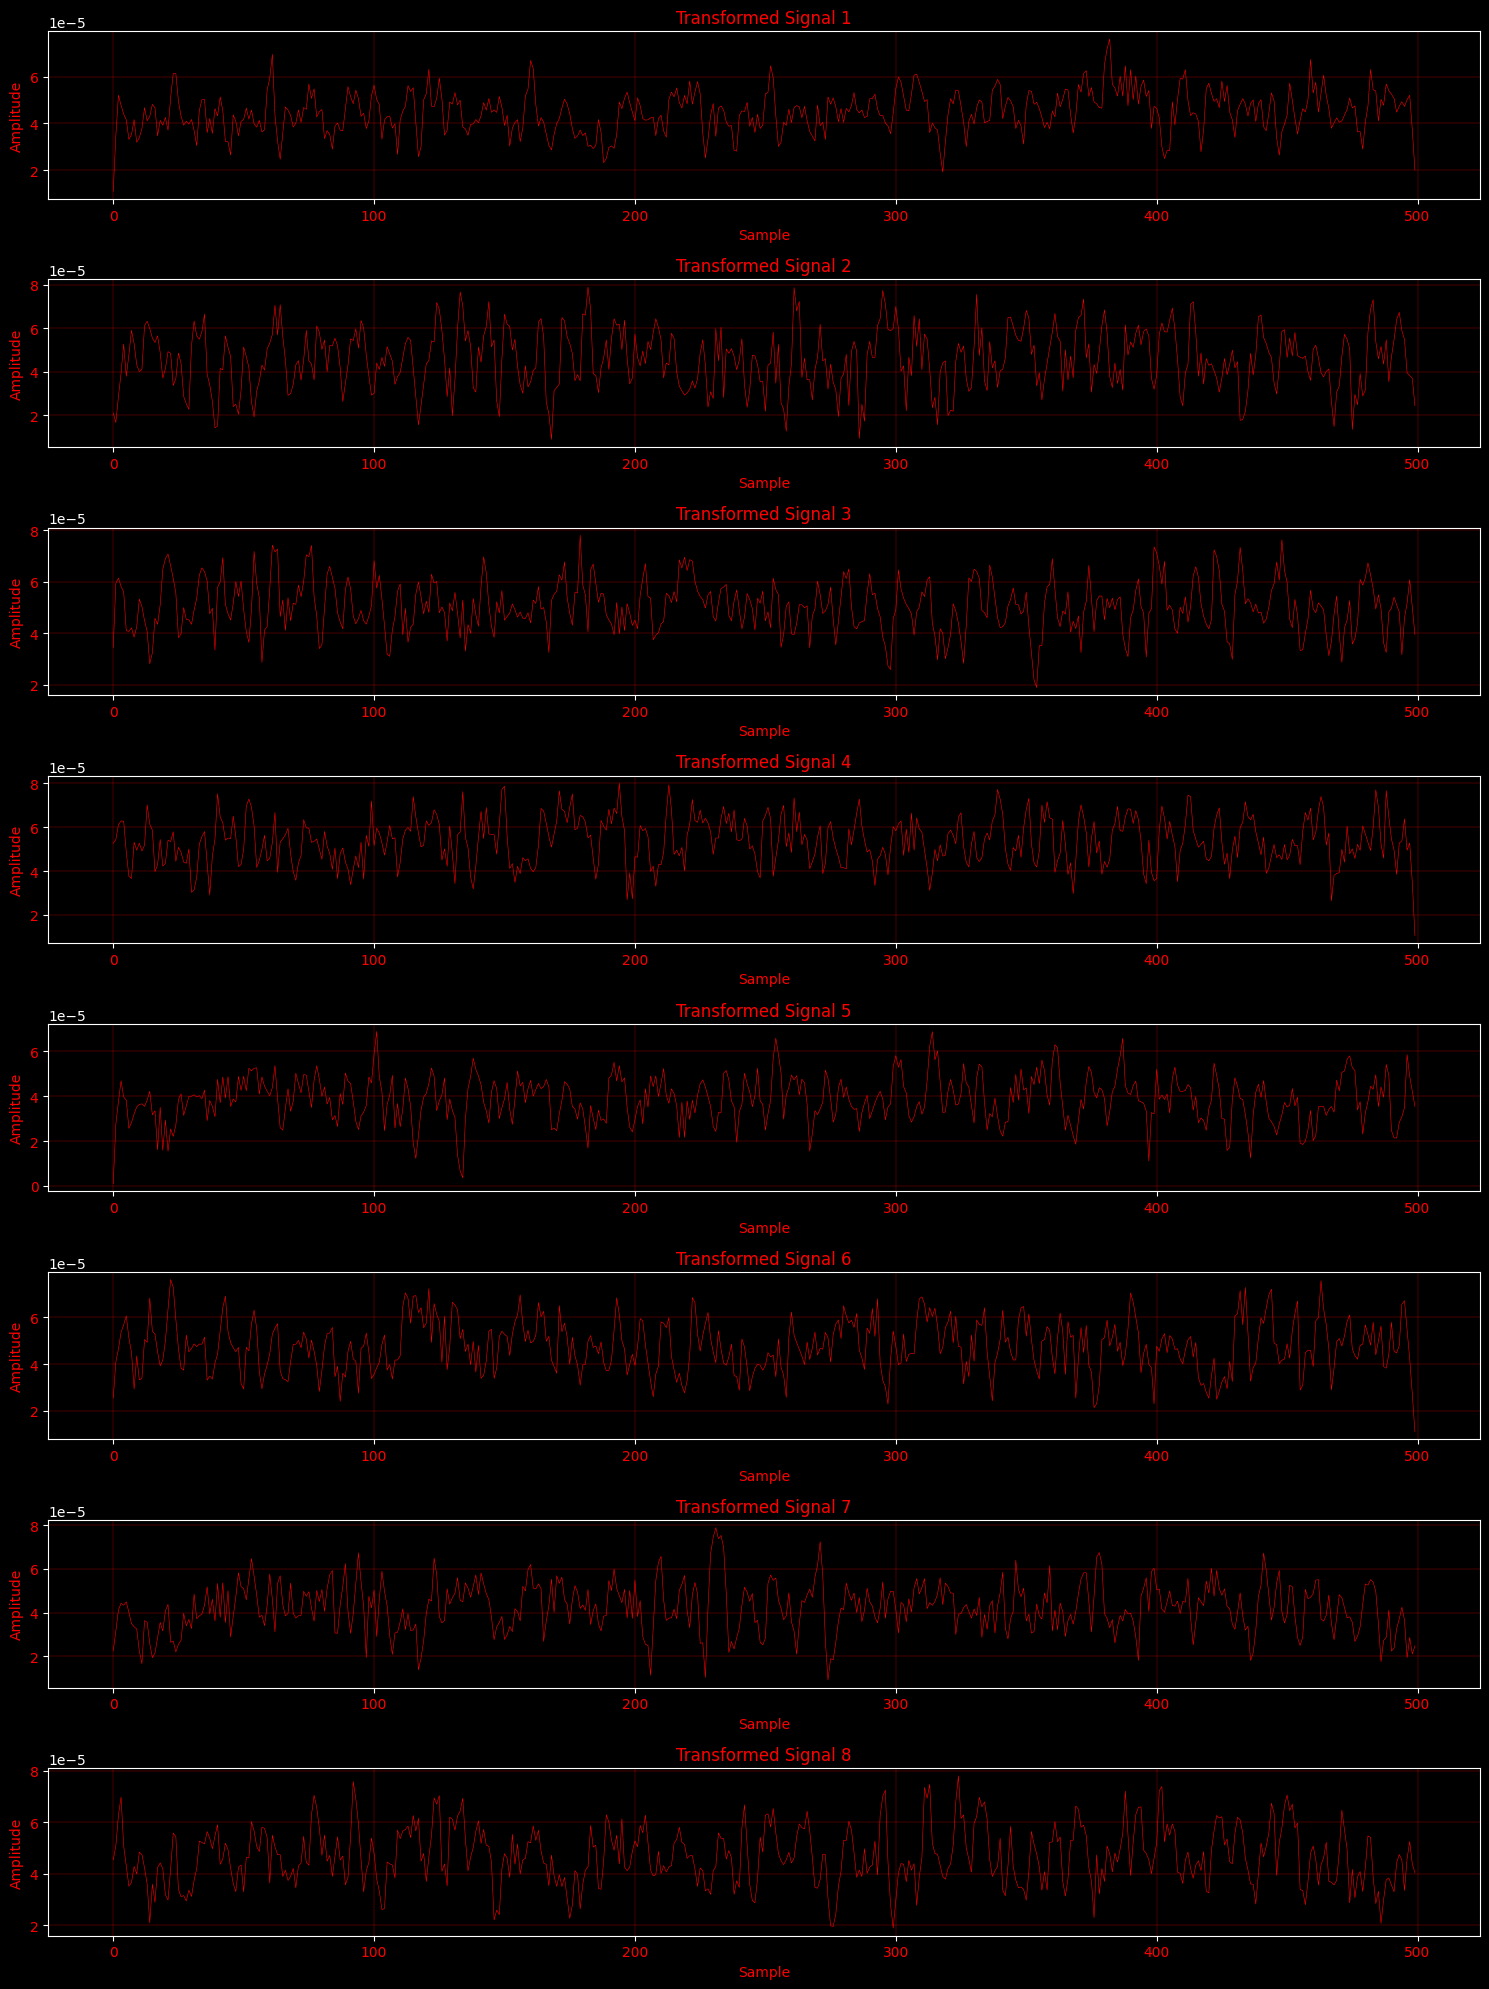

In [21]:
import matplotlib.pyplot as plt

def plot_separate_signals(signals, title_prefix):
    """
    Plot each signal in a separate subplot.

    Parameters:
    signals (numpy.ndarray): Array of signal arrays to plot.
    title_prefix (str): Prefix for the title of each plot.
    """
    num_signals = signals.shape[0]
    plt.figure(figsize=(15, 20))
    plt.style.use('dark_background')

    for i in range(num_signals):
        plt.subplot(num_signals, 1, i+1)
        plt.plot(signals[i], color='red', linewidth=0.4)  # Adjust the linewidth here
        plt.title(f'{title_prefix} Signal {i+1}', color='red')
        plt.xlabel('Sample', color='red')
        plt.ylabel('Amplitude', color='red')
        plt.xticks(color='red')
        plt.yticks(color='red')
        plt.grid(True, which='both', color='red', linestyle='-', linewidth=0.2)

    plt.tight_layout()
    plt.show()

# Plot the modified and transformed signals
#plot_separate_signals(modified_signals_array, 'Modified')
plot_separate_signals(transformed_signals, 'Transformed')

#### Stimulation

In [ ]:
import numpy as np
import time
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Database, StimPolarity, Experiment

# Assuming transformed_signals is accessible and has the shape (num_electrodes, signal_length)
# Example: transformed_signals = np.array([...]) with your actual transformed signals

token = "XSALK6J9C4"
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')  # Electrodes that you can use

# Configure stimulation parameters for each electrode using transformed_signals
stim_params = []
for index, signal in zip(exp.electrodes, transformed_signals):
    stim_param = StimParam()
    stim_param.index = index  # Set to current electrode in the loop

    # Set phase amplitudes based on some characteristic of the signal, e.g., its maximum value
    max_amplitude = np.max(signal)
    stim_param.phase_amplitude1 = max_amplitude
    stim_param.phase_amplitude2 = -max_amplitude  # Biphasic with opposite polarity

    # Configure unique trigger key for each electrode, assuming it's mapped to the index
    stim_param.trigger_key = index

    # Setting common stimulation parameters
    stim_param.phase_duration1 = 200.0
    stim_param.phase_duration2 = 200.0
    stim_param.stim_shape = StimShape.Biphasic
    stim_param.polarity = StimPolarity.PositiveFirst
    stim_param.enable_amp_settle = True
    stim_param.pre_stim_amp_settle = 0.0
    stim_param.post_stim_amp_settle = 1000.0
    stim_param.enable_charge_recovery = True
    stim_param.post_charge_recovery_on = 0.0
    stim_param.post_charge_recovery_off = 100.0
    stim_param.interphase_delay = 0.0

    stim_params.append(stim_param)


intan = IntanSoftware()
trigger_gen = Trigger()

try:
    if exp.start():  # Signal the start of an experiment to all users
        # Measure impedance
        intan.impedance()

        # Disable Variation STD (keep a fixed threshold)
        intan.var_threshold(False)

        # Send stim parameters
        intan.send_stimparam(stim_params)

        # Manually send trigger signals
        for stim_param in stim_params:
            trigger = np.zeros(16, dtype=np.uint8)
            trigger[stim_param.trigger_key] = 1

            for _ in range(40):  # Send trigger signal 40 times for each electrode
                time.sleep(5)  # Wait 5 seconds between each trigger
                trigger_gen.send(trigger)

        # Disable all stims
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)

finally:
    # Close the connection to trigger generator
    trigger_gen.close()
    # Enable variation threshold again
    intan.var_threshold(True)
    # Close the connection to intan software
    intan.close()
    # Signal the end of an experiment to all users
    exp.stop()